In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 네트워크 구축
class MNIST_NET(nn.Module) :
    def __init__(self) :
        super(MNIST_NET, self).__init__()
        
        # 입력채널 : gray scale이므로 1, 출력 채널(=필터 개수)
        # 10x24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0, bias=True)
        # 10x12x12
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        # 입력채널 : 이전 채널의 출력 개수, 출력 채널(=필터 개수)
        # 20x8x8
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0, bias=True)
        self.drop2 = nn.Dropout2d(p=0.5)
        # 20x4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        # 입력 채널 : 20x4x4(이전 layer flatten), 출력 채널(=Node 개수)
        self.fc1 = nn.Linear(in_features=320, out_features=50, bias=True)
        self.relu1_fc1 = nn.ReLU()
        self.drop1_fc1 = nn.Dropout2d(p=0.5)
        
        # 입력 채널 : 이전 채널의 출력 개수, 마지막층 출력 = 분류하려는 class 개수
        self.fc2 = nn.Linear(in_features=50, out_features=10, bias=True)
     
    # 앞에서 초기화 한 layer들을 연결해준다.
    def forward(self, x) :
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        
        # Flatten() -> 입력 채널 맞춰줘야함
        x = x.view(-1, 320)
        
        x = self.fc1(x)
        x = self.relu1_fc1(x)
        x = self.drop1_fc1(x)
        
        x = self.fc2(x)
        
        return x

In [4]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [5]:
## MNIST 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# 2. 데이터셋 불러오기
dataset = datasets.MNIST(download=True, root='./', train=True, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 60000개 = 64batch
# 1batch = 60000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

In [6]:
print(dataset)
print(loader)
print(num_data)
print(num_batch)
print(60000/64)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
60000
938.0
937.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([0, 7, 7, 5, 7, 6, 0, 0, 1, 6, 4, 2, 3, 6, 6, 4, 7, 4, 8, 9, 9, 0, 1, 9,
        2, 5, 6, 3, 7, 8, 0, 4, 7, 3, 8, 9, 6, 8, 4, 8, 5, 3, 9, 4, 9, 6, 0, 0,
        6, 3, 7, 9, 8, 7, 8, 0, 6, 2, 7, 3, 3, 1, 6, 0])


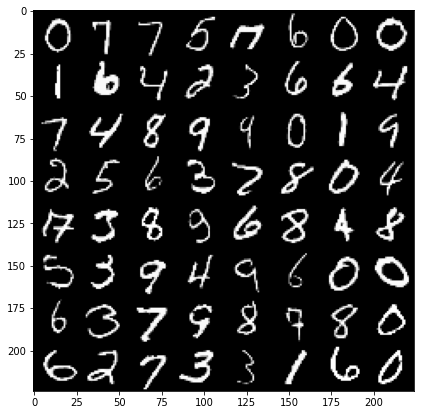

In [7]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(64개 이미지 존재)
dataiter = iter(loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 64개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [8]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = MNIST_NET().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)

writer = SummaryWriter(log_dir=log_dir)

In [9]:
## 모델 요약
print(summary(net, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         Dropout2d-5             [-1, 20, 8, 8]               0
         MaxPool2d-6             [-1, 20, 4, 4]               0
              ReLU-7             [-1, 20, 4, 4]               0
            Linear-8                   [-1, 50]          16,050
              ReLU-9                   [-1, 50]               0
        Dropout2d-10                   [-1, 50]               0
           Linear-11                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [10]:
## 트레이닝 시작하기
for epoch in range(1, num_epoch + 1):
    net.train()

    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = net(input)
        # output shape = (batch, 10)
#         print(output.shape)
        
        # pred shape = (batch, 10)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))

    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)

    save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)

writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0938 | LOSS: 2.3161 | ACC 0.0625
TRAIN: EPOCH 0001/0010 | BATCH 0002/0938 | LOSS: 2.3117 | ACC 0.0938
TRAIN: EPOCH 0001/0010 | BATCH 0003/0938 | LOSS: 2.3138 | ACC 0.1042
TRAIN: EPOCH 0001/0010 | BATCH 0004/0938 | LOSS: 2.3044 | ACC 0.1055
TRAIN: EPOCH 0001/0010 | BATCH 0005/0938 | LOSS: 2.3031 | ACC 0.1187
TRAIN: EPOCH 0001/0010 | BATCH 0006/0938 | LOSS: 2.3065 | ACC 0.1172
TRAIN: EPOCH 0001/0010 | BATCH 0007/0938 | LOSS: 2.3052 | ACC 0.1138
TRAIN: EPOCH 0001/0010 | BATCH 0008/0938 | LOSS: 2.3015 | ACC 0.1152
TRAIN: EPOCH 0001/0010 | BATCH 0009/0938 | LOSS: 2.2949 | ACC 0.1181
TRAIN: EPOCH 0001/0010 | BATCH 0010/0938 | LOSS: 2.2922 | ACC 0.1156
TRAIN: EPOCH 0001/0010 | BATCH 0011/0938 | LOSS: 2.2910 | ACC 0.1108
TRAIN: EPOCH 0001/0010 | BATCH 0012/0938 | LOSS: 2.2884 | ACC 0.1146
TRAIN: EPOCH 0001/0010 | BATCH 0013/0938 | LOSS: 2.2851 | ACC 0.1202
TRAIN: EPOCH 0001/0010 | BATCH 0014/0938 | LOSS: 2.2798 | ACC 0.1228
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0001/0010 | BATCH 0126/0938 | LOSS: 1.4938 | ACC 0.4880
TRAIN: EPOCH 0001/0010 | BATCH 0127/0938 | LOSS: 1.4876 | ACC 0.4903
TRAIN: EPOCH 0001/0010 | BATCH 0128/0938 | LOSS: 1.4810 | ACC 0.4927
TRAIN: EPOCH 0001/0010 | BATCH 0129/0938 | LOSS: 1.4751 | ACC 0.4949
TRAIN: EPOCH 0001/0010 | BATCH 0130/0938 | LOSS: 1.4701 | ACC 0.4966
TRAIN: EPOCH 0001/0010 | BATCH 0131/0938 | LOSS: 1.4653 | ACC 0.4987
TRAIN: EPOCH 0001/0010 | BATCH 0132/0938 | LOSS: 1.4608 | ACC 0.5006
TRAIN: EPOCH 0001/0010 | BATCH 0133/0938 | LOSS: 1.4544 | ACC 0.5028
TRAIN: EPOCH 0001/0010 | BATCH 0134/0938 | LOSS: 1.4495 | ACC 0.5048
TRAIN: EPOCH 0001/0010 | BATCH 0135/0938 | LOSS: 1.4445 | ACC 0.5065
TRAIN: EPOCH 0001/0010 | BATCH 0136/0938 | LOSS: 1.4401 | ACC 0.5074
TRAIN: EPOCH 0001/0010 | BATCH 0137/0938 | LOSS: 1.4353 | ACC 0.5090
TRAIN: EPOCH 0001/0010 | BATCH 0138/0938 | LOSS: 1.4318 | ACC 0.5110
TRAIN: EPOCH 0001/0010 | BATCH 0139/0938 | LOSS: 1.4270 | ACC 0.5128
TRAIN: EPOCH 0001/0010 | BATCH 014

TRAIN: EPOCH 0001/0010 | BATCH 0246/0938 | LOSS: 1.1094 | ACC 0.6301
TRAIN: EPOCH 0001/0010 | BATCH 0247/0938 | LOSS: 1.1071 | ACC 0.6308
TRAIN: EPOCH 0001/0010 | BATCH 0248/0938 | LOSS: 1.1050 | ACC 0.6314
TRAIN: EPOCH 0001/0010 | BATCH 0249/0938 | LOSS: 1.1028 | ACC 0.6323
TRAIN: EPOCH 0001/0010 | BATCH 0250/0938 | LOSS: 1.1014 | ACC 0.6328
TRAIN: EPOCH 0001/0010 | BATCH 0251/0938 | LOSS: 1.0987 | ACC 0.6338
TRAIN: EPOCH 0001/0010 | BATCH 0252/0938 | LOSS: 1.0972 | ACC 0.6344
TRAIN: EPOCH 0001/0010 | BATCH 0253/0938 | LOSS: 1.0951 | ACC 0.6351
TRAIN: EPOCH 0001/0010 | BATCH 0254/0938 | LOSS: 1.0925 | ACC 0.6361
TRAIN: EPOCH 0001/0010 | BATCH 0255/0938 | LOSS: 1.0902 | ACC 0.6368
TRAIN: EPOCH 0001/0010 | BATCH 0256/0938 | LOSS: 1.0876 | ACC 0.6376
TRAIN: EPOCH 0001/0010 | BATCH 0257/0938 | LOSS: 1.0855 | ACC 0.6381
TRAIN: EPOCH 0001/0010 | BATCH 0258/0938 | LOSS: 1.0834 | ACC 0.6388
TRAIN: EPOCH 0001/0010 | BATCH 0259/0938 | LOSS: 1.0811 | ACC 0.6398
TRAIN: EPOCH 0001/0010 | BATCH 026

TRAIN: EPOCH 0001/0010 | BATCH 0366/0938 | LOSS: 0.9114 | ACC 0.7012
TRAIN: EPOCH 0001/0010 | BATCH 0367/0938 | LOSS: 0.9108 | ACC 0.7015
TRAIN: EPOCH 0001/0010 | BATCH 0368/0938 | LOSS: 0.9098 | ACC 0.7019
TRAIN: EPOCH 0001/0010 | BATCH 0369/0938 | LOSS: 0.9086 | ACC 0.7023
TRAIN: EPOCH 0001/0010 | BATCH 0370/0938 | LOSS: 0.9077 | ACC 0.7024
TRAIN: EPOCH 0001/0010 | BATCH 0371/0938 | LOSS: 0.9065 | ACC 0.7028
TRAIN: EPOCH 0001/0010 | BATCH 0372/0938 | LOSS: 0.9052 | ACC 0.7033
TRAIN: EPOCH 0001/0010 | BATCH 0373/0938 | LOSS: 0.9042 | ACC 0.7036
TRAIN: EPOCH 0001/0010 | BATCH 0374/0938 | LOSS: 0.9026 | ACC 0.7042
TRAIN: EPOCH 0001/0010 | BATCH 0375/0938 | LOSS: 0.9015 | ACC 0.7045
TRAIN: EPOCH 0001/0010 | BATCH 0376/0938 | LOSS: 0.9001 | ACC 0.7051
TRAIN: EPOCH 0001/0010 | BATCH 0377/0938 | LOSS: 0.8990 | ACC 0.7054
TRAIN: EPOCH 0001/0010 | BATCH 0378/0938 | LOSS: 0.8978 | ACC 0.7058
TRAIN: EPOCH 0001/0010 | BATCH 0379/0938 | LOSS: 0.8961 | ACC 0.7064
TRAIN: EPOCH 0001/0010 | BATCH 038

TRAIN: EPOCH 0001/0010 | BATCH 0489/0938 | LOSS: 0.7911 | ACC 0.7428
TRAIN: EPOCH 0001/0010 | BATCH 0490/0938 | LOSS: 0.7902 | ACC 0.7431
TRAIN: EPOCH 0001/0010 | BATCH 0491/0938 | LOSS: 0.7895 | ACC 0.7432
TRAIN: EPOCH 0001/0010 | BATCH 0492/0938 | LOSS: 0.7897 | ACC 0.7433
TRAIN: EPOCH 0001/0010 | BATCH 0493/0938 | LOSS: 0.7887 | ACC 0.7437
TRAIN: EPOCH 0001/0010 | BATCH 0494/0938 | LOSS: 0.7881 | ACC 0.7439
TRAIN: EPOCH 0001/0010 | BATCH 0495/0938 | LOSS: 0.7873 | ACC 0.7441
TRAIN: EPOCH 0001/0010 | BATCH 0496/0938 | LOSS: 0.7865 | ACC 0.7444
TRAIN: EPOCH 0001/0010 | BATCH 0497/0938 | LOSS: 0.7857 | ACC 0.7446
TRAIN: EPOCH 0001/0010 | BATCH 0498/0938 | LOSS: 0.7849 | ACC 0.7449
TRAIN: EPOCH 0001/0010 | BATCH 0499/0938 | LOSS: 0.7843 | ACC 0.7452
TRAIN: EPOCH 0001/0010 | BATCH 0500/0938 | LOSS: 0.7839 | ACC 0.7454
TRAIN: EPOCH 0001/0010 | BATCH 0501/0938 | LOSS: 0.7829 | ACC 0.7457
TRAIN: EPOCH 0001/0010 | BATCH 0502/0938 | LOSS: 0.7824 | ACC 0.7459
TRAIN: EPOCH 0001/0010 | BATCH 050

TRAIN: EPOCH 0001/0010 | BATCH 0609/0938 | LOSS: 0.7117 | ACC 0.7700
TRAIN: EPOCH 0001/0010 | BATCH 0610/0938 | LOSS: 0.7113 | ACC 0.7701
TRAIN: EPOCH 0001/0010 | BATCH 0611/0938 | LOSS: 0.7105 | ACC 0.7704
TRAIN: EPOCH 0001/0010 | BATCH 0612/0938 | LOSS: 0.7101 | ACC 0.7705
TRAIN: EPOCH 0001/0010 | BATCH 0613/0938 | LOSS: 0.7097 | ACC 0.7707
TRAIN: EPOCH 0001/0010 | BATCH 0614/0938 | LOSS: 0.7088 | ACC 0.7710
TRAIN: EPOCH 0001/0010 | BATCH 0615/0938 | LOSS: 0.7085 | ACC 0.7711
TRAIN: EPOCH 0001/0010 | BATCH 0616/0938 | LOSS: 0.7080 | ACC 0.7713
TRAIN: EPOCH 0001/0010 | BATCH 0617/0938 | LOSS: 0.7076 | ACC 0.7714
TRAIN: EPOCH 0001/0010 | BATCH 0618/0938 | LOSS: 0.7069 | ACC 0.7716
TRAIN: EPOCH 0001/0010 | BATCH 0619/0938 | LOSS: 0.7065 | ACC 0.7718
TRAIN: EPOCH 0001/0010 | BATCH 0620/0938 | LOSS: 0.7060 | ACC 0.7719
TRAIN: EPOCH 0001/0010 | BATCH 0621/0938 | LOSS: 0.7054 | ACC 0.7721
TRAIN: EPOCH 0001/0010 | BATCH 0622/0938 | LOSS: 0.7047 | ACC 0.7723
TRAIN: EPOCH 0001/0010 | BATCH 062

TRAIN: EPOCH 0001/0010 | BATCH 0735/0938 | LOSS: 0.6480 | ACC 0.7919
TRAIN: EPOCH 0001/0010 | BATCH 0736/0938 | LOSS: 0.6478 | ACC 0.7920
TRAIN: EPOCH 0001/0010 | BATCH 0737/0938 | LOSS: 0.6475 | ACC 0.7921
TRAIN: EPOCH 0001/0010 | BATCH 0738/0938 | LOSS: 0.6471 | ACC 0.7922
TRAIN: EPOCH 0001/0010 | BATCH 0739/0938 | LOSS: 0.6467 | ACC 0.7924
TRAIN: EPOCH 0001/0010 | BATCH 0740/0938 | LOSS: 0.6462 | ACC 0.7925
TRAIN: EPOCH 0001/0010 | BATCH 0741/0938 | LOSS: 0.6458 | ACC 0.7926
TRAIN: EPOCH 0001/0010 | BATCH 0742/0938 | LOSS: 0.6454 | ACC 0.7927
TRAIN: EPOCH 0001/0010 | BATCH 0743/0938 | LOSS: 0.6449 | ACC 0.7928
TRAIN: EPOCH 0001/0010 | BATCH 0744/0938 | LOSS: 0.6445 | ACC 0.7929
TRAIN: EPOCH 0001/0010 | BATCH 0745/0938 | LOSS: 0.6440 | ACC 0.7931
TRAIN: EPOCH 0001/0010 | BATCH 0746/0938 | LOSS: 0.6434 | ACC 0.7933
TRAIN: EPOCH 0001/0010 | BATCH 0747/0938 | LOSS: 0.6430 | ACC 0.7934
TRAIN: EPOCH 0001/0010 | BATCH 0748/0938 | LOSS: 0.6425 | ACC 0.7936
TRAIN: EPOCH 0001/0010 | BATCH 074

TRAIN: EPOCH 0001/0010 | BATCH 0866/0938 | LOSS: 0.5989 | ACC 0.8084
TRAIN: EPOCH 0001/0010 | BATCH 0867/0938 | LOSS: 0.5988 | ACC 0.8085
TRAIN: EPOCH 0001/0010 | BATCH 0868/0938 | LOSS: 0.5984 | ACC 0.8086
TRAIN: EPOCH 0001/0010 | BATCH 0869/0938 | LOSS: 0.5979 | ACC 0.8087
TRAIN: EPOCH 0001/0010 | BATCH 0870/0938 | LOSS: 0.5974 | ACC 0.8089
TRAIN: EPOCH 0001/0010 | BATCH 0871/0938 | LOSS: 0.5971 | ACC 0.8091
TRAIN: EPOCH 0001/0010 | BATCH 0872/0938 | LOSS: 0.5966 | ACC 0.8092
TRAIN: EPOCH 0001/0010 | BATCH 0873/0938 | LOSS: 0.5963 | ACC 0.8093
TRAIN: EPOCH 0001/0010 | BATCH 0874/0938 | LOSS: 0.5962 | ACC 0.8094
TRAIN: EPOCH 0001/0010 | BATCH 0875/0938 | LOSS: 0.5960 | ACC 0.8095
TRAIN: EPOCH 0001/0010 | BATCH 0876/0938 | LOSS: 0.5958 | ACC 0.8096
TRAIN: EPOCH 0001/0010 | BATCH 0877/0938 | LOSS: 0.5954 | ACC 0.8098
TRAIN: EPOCH 0001/0010 | BATCH 0878/0938 | LOSS: 0.5951 | ACC 0.8099
TRAIN: EPOCH 0001/0010 | BATCH 0879/0938 | LOSS: 0.5947 | ACC 0.8100
TRAIN: EPOCH 0001/0010 | BATCH 088

TRAIN: EPOCH 0002/0010 | BATCH 0056/0938 | LOSS: 0.2844 | ACC 0.9160
TRAIN: EPOCH 0002/0010 | BATCH 0057/0938 | LOSS: 0.2833 | ACC 0.9164
TRAIN: EPOCH 0002/0010 | BATCH 0058/0938 | LOSS: 0.2859 | ACC 0.9159
TRAIN: EPOCH 0002/0010 | BATCH 0059/0938 | LOSS: 0.2856 | ACC 0.9163
TRAIN: EPOCH 0002/0010 | BATCH 0060/0938 | LOSS: 0.2852 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0061/0938 | LOSS: 0.2851 | ACC 0.9157
TRAIN: EPOCH 0002/0010 | BATCH 0062/0938 | LOSS: 0.2862 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0063/0938 | LOSS: 0.2881 | ACC 0.9152
TRAIN: EPOCH 0002/0010 | BATCH 0064/0938 | LOSS: 0.2895 | ACC 0.9148
TRAIN: EPOCH 0002/0010 | BATCH 0065/0938 | LOSS: 0.2870 | ACC 0.9156
TRAIN: EPOCH 0002/0010 | BATCH 0066/0938 | LOSS: 0.2865 | ACC 0.9160
TRAIN: EPOCH 0002/0010 | BATCH 0067/0938 | LOSS: 0.2844 | ACC 0.9165
TRAIN: EPOCH 0002/0010 | BATCH 0068/0938 | LOSS: 0.2837 | ACC 0.9168
TRAIN: EPOCH 0002/0010 | BATCH 0069/0938 | LOSS: 0.2825 | ACC 0.9173
TRAIN: EPOCH 0002/0010 | BATCH 007

TRAIN: EPOCH 0002/0010 | BATCH 0180/0938 | LOSS: 0.2969 | ACC 0.9123
TRAIN: EPOCH 0002/0010 | BATCH 0181/0938 | LOSS: 0.2965 | ACC 0.9125
TRAIN: EPOCH 0002/0010 | BATCH 0182/0938 | LOSS: 0.2958 | ACC 0.9126
TRAIN: EPOCH 0002/0010 | BATCH 0183/0938 | LOSS: 0.2958 | ACC 0.9127
TRAIN: EPOCH 0002/0010 | BATCH 0184/0938 | LOSS: 0.2951 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0185/0938 | LOSS: 0.2955 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0186/0938 | LOSS: 0.2952 | ACC 0.9131
TRAIN: EPOCH 0002/0010 | BATCH 0187/0938 | LOSS: 0.2948 | ACC 0.9133
TRAIN: EPOCH 0002/0010 | BATCH 0188/0938 | LOSS: 0.2951 | ACC 0.9132
TRAIN: EPOCH 0002/0010 | BATCH 0189/0938 | LOSS: 0.2958 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0190/0938 | LOSS: 0.2956 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0191/0938 | LOSS: 0.2960 | ACC 0.9128
TRAIN: EPOCH 0002/0010 | BATCH 0192/0938 | LOSS: 0.2955 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0193/0938 | LOSS: 0.2958 | ACC 0.9131
TRAIN: EPOCH 0002/0010 | BATCH 019

TRAIN: EPOCH 0002/0010 | BATCH 0303/0938 | LOSS: 0.2925 | ACC 0.9124
TRAIN: EPOCH 0002/0010 | BATCH 0304/0938 | LOSS: 0.2923 | ACC 0.9124
TRAIN: EPOCH 0002/0010 | BATCH 0305/0938 | LOSS: 0.2926 | ACC 0.9125
TRAIN: EPOCH 0002/0010 | BATCH 0306/0938 | LOSS: 0.2924 | ACC 0.9126
TRAIN: EPOCH 0002/0010 | BATCH 0307/0938 | LOSS: 0.2923 | ACC 0.9125
TRAIN: EPOCH 0002/0010 | BATCH 0308/0938 | LOSS: 0.2927 | ACC 0.9125
TRAIN: EPOCH 0002/0010 | BATCH 0309/0938 | LOSS: 0.2929 | ACC 0.9122
TRAIN: EPOCH 0002/0010 | BATCH 0310/0938 | LOSS: 0.2932 | ACC 0.9121
TRAIN: EPOCH 0002/0010 | BATCH 0311/0938 | LOSS: 0.2928 | ACC 0.9123
TRAIN: EPOCH 0002/0010 | BATCH 0312/0938 | LOSS: 0.2929 | ACC 0.9122
TRAIN: EPOCH 0002/0010 | BATCH 0313/0938 | LOSS: 0.2926 | ACC 0.9123
TRAIN: EPOCH 0002/0010 | BATCH 0314/0938 | LOSS: 0.2925 | ACC 0.9124
TRAIN: EPOCH 0002/0010 | BATCH 0315/0938 | LOSS: 0.2926 | ACC 0.9123
TRAIN: EPOCH 0002/0010 | BATCH 0316/0938 | LOSS: 0.2923 | ACC 0.9123
TRAIN: EPOCH 0002/0010 | BATCH 031

TRAIN: EPOCH 0002/0010 | BATCH 0422/0938 | LOSS: 0.2896 | ACC 0.9126
TRAIN: EPOCH 0002/0010 | BATCH 0423/0938 | LOSS: 0.2895 | ACC 0.9127
TRAIN: EPOCH 0002/0010 | BATCH 0424/0938 | LOSS: 0.2891 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0425/0938 | LOSS: 0.2889 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0426/0938 | LOSS: 0.2887 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0427/0938 | LOSS: 0.2890 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0428/0938 | LOSS: 0.2890 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0429/0938 | LOSS: 0.2893 | ACC 0.9128
TRAIN: EPOCH 0002/0010 | BATCH 0430/0938 | LOSS: 0.2892 | ACC 0.9128
TRAIN: EPOCH 0002/0010 | BATCH 0431/0938 | LOSS: 0.2891 | ACC 0.9128
TRAIN: EPOCH 0002/0010 | BATCH 0432/0938 | LOSS: 0.2887 | ACC 0.9129
TRAIN: EPOCH 0002/0010 | BATCH 0433/0938 | LOSS: 0.2886 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0434/0938 | LOSS: 0.2885 | ACC 0.9130
TRAIN: EPOCH 0002/0010 | BATCH 0435/0938 | LOSS: 0.2886 | ACC 0.9131
TRAIN: EPOCH 0002/0010 | BATCH 043

TRAIN: EPOCH 0002/0010 | BATCH 0546/0938 | LOSS: 0.2774 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0547/0938 | LOSS: 0.2773 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0548/0938 | LOSS: 0.2775 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0549/0938 | LOSS: 0.2775 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0550/0938 | LOSS: 0.2774 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0551/0938 | LOSS: 0.2773 | ACC 0.9162
TRAIN: EPOCH 0002/0010 | BATCH 0552/0938 | LOSS: 0.2773 | ACC 0.9161
TRAIN: EPOCH 0002/0010 | BATCH 0553/0938 | LOSS: 0.2770 | ACC 0.9162
TRAIN: EPOCH 0002/0010 | BATCH 0554/0938 | LOSS: 0.2771 | ACC 0.9162
TRAIN: EPOCH 0002/0010 | BATCH 0555/0938 | LOSS: 0.2769 | ACC 0.9162
TRAIN: EPOCH 0002/0010 | BATCH 0556/0938 | LOSS: 0.2767 | ACC 0.9163
TRAIN: EPOCH 0002/0010 | BATCH 0557/0938 | LOSS: 0.2767 | ACC 0.9163
TRAIN: EPOCH 0002/0010 | BATCH 0558/0938 | LOSS: 0.2764 | ACC 0.9164
TRAIN: EPOCH 0002/0010 | BATCH 0559/0938 | LOSS: 0.2762 | ACC 0.9165
TRAIN: EPOCH 0002/0010 | BATCH 056

TRAIN: EPOCH 0002/0010 | BATCH 0670/0938 | LOSS: 0.2734 | ACC 0.9180
TRAIN: EPOCH 0002/0010 | BATCH 0671/0938 | LOSS: 0.2737 | ACC 0.9180
TRAIN: EPOCH 0002/0010 | BATCH 0672/0938 | LOSS: 0.2735 | ACC 0.9180
TRAIN: EPOCH 0002/0010 | BATCH 0673/0938 | LOSS: 0.2734 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0674/0938 | LOSS: 0.2735 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0675/0938 | LOSS: 0.2736 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0676/0938 | LOSS: 0.2736 | ACC 0.9180
TRAIN: EPOCH 0002/0010 | BATCH 0677/0938 | LOSS: 0.2734 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0678/0938 | LOSS: 0.2732 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0679/0938 | LOSS: 0.2733 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0680/0938 | LOSS: 0.2732 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0681/0938 | LOSS: 0.2735 | ACC 0.9180
TRAIN: EPOCH 0002/0010 | BATCH 0682/0938 | LOSS: 0.2735 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 0683/0938 | LOSS: 0.2735 | ACC 0.9181
TRAIN: EPOCH 0002/0010 | BATCH 068

TRAIN: EPOCH 0002/0010 | BATCH 0796/0938 | LOSS: 0.2703 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0797/0938 | LOSS: 0.2702 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0798/0938 | LOSS: 0.2702 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0799/0938 | LOSS: 0.2706 | ACC 0.9189
TRAIN: EPOCH 0002/0010 | BATCH 0800/0938 | LOSS: 0.2704 | ACC 0.9189
TRAIN: EPOCH 0002/0010 | BATCH 0801/0938 | LOSS: 0.2704 | ACC 0.9189
TRAIN: EPOCH 0002/0010 | BATCH 0802/0938 | LOSS: 0.2704 | ACC 0.9189
TRAIN: EPOCH 0002/0010 | BATCH 0803/0938 | LOSS: 0.2703 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0804/0938 | LOSS: 0.2702 | ACC 0.9189
TRAIN: EPOCH 0002/0010 | BATCH 0805/0938 | LOSS: 0.2701 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0806/0938 | LOSS: 0.2701 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0807/0938 | LOSS: 0.2698 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0808/0938 | LOSS: 0.2698 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 0809/0938 | LOSS: 0.2696 | ACC 0.9190
TRAIN: EPOCH 0002/0010 | BATCH 081

TRAIN: EPOCH 0002/0010 | BATCH 0927/0938 | LOSS: 0.2663 | ACC 0.9202
TRAIN: EPOCH 0002/0010 | BATCH 0928/0938 | LOSS: 0.2663 | ACC 0.9202
TRAIN: EPOCH 0002/0010 | BATCH 0929/0938 | LOSS: 0.2664 | ACC 0.9202
TRAIN: EPOCH 0002/0010 | BATCH 0930/0938 | LOSS: 0.2662 | ACC 0.9202
TRAIN: EPOCH 0002/0010 | BATCH 0931/0938 | LOSS: 0.2663 | ACC 0.9202
TRAIN: EPOCH 0002/0010 | BATCH 0932/0938 | LOSS: 0.2662 | ACC 0.9203
TRAIN: EPOCH 0002/0010 | BATCH 0933/0938 | LOSS: 0.2661 | ACC 0.9204
TRAIN: EPOCH 0002/0010 | BATCH 0934/0938 | LOSS: 0.2659 | ACC 0.9204
TRAIN: EPOCH 0002/0010 | BATCH 0935/0938 | LOSS: 0.2657 | ACC 0.9205
TRAIN: EPOCH 0002/0010 | BATCH 0936/0938 | LOSS: 0.2659 | ACC 0.9205
TRAIN: EPOCH 0002/0010 | BATCH 0937/0938 | LOSS: 0.2657 | ACC 0.9205
TRAIN: EPOCH 0002/0010 | BATCH 0938/0938 | LOSS: 0.2658 | ACC 0.9205
TRAIN: EPOCH 0003/0010 | BATCH 0001/0938 | LOSS: 0.1972 | ACC 0.9531
TRAIN: EPOCH 0003/0010 | BATCH 0002/0938 | LOSS: 0.2058 | ACC 0.9297
TRAIN: EPOCH 0003/0010 | BATCH 000

TRAIN: EPOCH 0003/0010 | BATCH 0114/0938 | LOSS: 0.2271 | ACC 0.9341
TRAIN: EPOCH 0003/0010 | BATCH 0115/0938 | LOSS: 0.2261 | ACC 0.9342
TRAIN: EPOCH 0003/0010 | BATCH 0116/0938 | LOSS: 0.2260 | ACC 0.9341
TRAIN: EPOCH 0003/0010 | BATCH 0117/0938 | LOSS: 0.2250 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0118/0938 | LOSS: 0.2253 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0119/0938 | LOSS: 0.2251 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0120/0938 | LOSS: 0.2246 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0121/0938 | LOSS: 0.2253 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0122/0938 | LOSS: 0.2259 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0123/0938 | LOSS: 0.2254 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0124/0938 | LOSS: 0.2260 | ACC 0.9341
TRAIN: EPOCH 0003/0010 | BATCH 0125/0938 | LOSS: 0.2260 | ACC 0.9341
TRAIN: EPOCH 0003/0010 | BATCH 0126/0938 | LOSS: 0.2258 | ACC 0.9340
TRAIN: EPOCH 0003/0010 | BATCH 0127/0938 | LOSS: 0.2254 | ACC 0.9339
TRAIN: EPOCH 0003/0010 | BATCH 012

TRAIN: EPOCH 0003/0010 | BATCH 0237/0938 | LOSS: 0.2197 | ACC 0.9358
TRAIN: EPOCH 0003/0010 | BATCH 0238/0938 | LOSS: 0.2194 | ACC 0.9359
TRAIN: EPOCH 0003/0010 | BATCH 0239/0938 | LOSS: 0.2190 | ACC 0.9359
TRAIN: EPOCH 0003/0010 | BATCH 0240/0938 | LOSS: 0.2186 | ACC 0.9359
TRAIN: EPOCH 0003/0010 | BATCH 0241/0938 | LOSS: 0.2195 | ACC 0.9357
TRAIN: EPOCH 0003/0010 | BATCH 0242/0938 | LOSS: 0.2191 | ACC 0.9357
TRAIN: EPOCH 0003/0010 | BATCH 0243/0938 | LOSS: 0.2191 | ACC 0.9357
TRAIN: EPOCH 0003/0010 | BATCH 0244/0938 | LOSS: 0.2193 | ACC 0.9357
TRAIN: EPOCH 0003/0010 | BATCH 0245/0938 | LOSS: 0.2193 | ACC 0.9356
TRAIN: EPOCH 0003/0010 | BATCH 0246/0938 | LOSS: 0.2201 | ACC 0.9353
TRAIN: EPOCH 0003/0010 | BATCH 0247/0938 | LOSS: 0.2200 | ACC 0.9353
TRAIN: EPOCH 0003/0010 | BATCH 0248/0938 | LOSS: 0.2199 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0249/0938 | LOSS: 0.2203 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0250/0938 | LOSS: 0.2200 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 025

TRAIN: EPOCH 0003/0010 | BATCH 0360/0938 | LOSS: 0.2208 | ACC 0.9355
TRAIN: EPOCH 0003/0010 | BATCH 0361/0938 | LOSS: 0.2206 | ACC 0.9355
TRAIN: EPOCH 0003/0010 | BATCH 0362/0938 | LOSS: 0.2208 | ACC 0.9355
TRAIN: EPOCH 0003/0010 | BATCH 0363/0938 | LOSS: 0.2211 | ACC 0.9354
TRAIN: EPOCH 0003/0010 | BATCH 0364/0938 | LOSS: 0.2211 | ACC 0.9353
TRAIN: EPOCH 0003/0010 | BATCH 0365/0938 | LOSS: 0.2213 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0366/0938 | LOSS: 0.2213 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0367/0938 | LOSS: 0.2218 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0368/0938 | LOSS: 0.2217 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0369/0938 | LOSS: 0.2217 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0370/0938 | LOSS: 0.2217 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0371/0938 | LOSS: 0.2214 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0372/0938 | LOSS: 0.2220 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0373/0938 | LOSS: 0.2216 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 037

TRAIN: EPOCH 0003/0010 | BATCH 0488/0938 | LOSS: 0.2195 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0489/0938 | LOSS: 0.2195 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0490/0938 | LOSS: 0.2196 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0491/0938 | LOSS: 0.2199 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0492/0938 | LOSS: 0.2197 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0493/0938 | LOSS: 0.2199 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0494/0938 | LOSS: 0.2200 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0495/0938 | LOSS: 0.2202 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0496/0938 | LOSS: 0.2203 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0497/0938 | LOSS: 0.2203 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0498/0938 | LOSS: 0.2206 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0499/0938 | LOSS: 0.2205 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0500/0938 | LOSS: 0.2207 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0501/0938 | LOSS: 0.2206 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 050

TRAIN: EPOCH 0003/0010 | BATCH 0608/0938 | LOSS: 0.2209 | ACC 0.9344
TRAIN: EPOCH 0003/0010 | BATCH 0609/0938 | LOSS: 0.2212 | ACC 0.9344
TRAIN: EPOCH 0003/0010 | BATCH 0610/0938 | LOSS: 0.2211 | ACC 0.9345
TRAIN: EPOCH 0003/0010 | BATCH 0611/0938 | LOSS: 0.2210 | ACC 0.9345
TRAIN: EPOCH 0003/0010 | BATCH 0612/0938 | LOSS: 0.2210 | ACC 0.9344
TRAIN: EPOCH 0003/0010 | BATCH 0613/0938 | LOSS: 0.2210 | ACC 0.9345
TRAIN: EPOCH 0003/0010 | BATCH 0614/0938 | LOSS: 0.2209 | ACC 0.9345
TRAIN: EPOCH 0003/0010 | BATCH 0615/0938 | LOSS: 0.2208 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0616/0938 | LOSS: 0.2207 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0617/0938 | LOSS: 0.2206 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0618/0938 | LOSS: 0.2204 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0619/0938 | LOSS: 0.2205 | ACC 0.9346
TRAIN: EPOCH 0003/0010 | BATCH 0620/0938 | LOSS: 0.2203 | ACC 0.9347
TRAIN: EPOCH 0003/0010 | BATCH 0621/0938 | LOSS: 0.2201 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 062

TRAIN: EPOCH 0003/0010 | BATCH 0731/0938 | LOSS: 0.2206 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0732/0938 | LOSS: 0.2205 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0733/0938 | LOSS: 0.2204 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0734/0938 | LOSS: 0.2203 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0735/0938 | LOSS: 0.2202 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0736/0938 | LOSS: 0.2203 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0737/0938 | LOSS: 0.2204 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0738/0938 | LOSS: 0.2203 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0739/0938 | LOSS: 0.2201 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0740/0938 | LOSS: 0.2202 | ACC 0.9348
TRAIN: EPOCH 0003/0010 | BATCH 0741/0938 | LOSS: 0.2201 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0742/0938 | LOSS: 0.2199 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0743/0938 | LOSS: 0.2198 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0744/0938 | LOSS: 0.2199 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 074

TRAIN: EPOCH 0003/0010 | BATCH 0857/0938 | LOSS: 0.2201 | ACC 0.9349
TRAIN: EPOCH 0003/0010 | BATCH 0858/0938 | LOSS: 0.2200 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0859/0938 | LOSS: 0.2199 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0860/0938 | LOSS: 0.2198 | ACC 0.9350
TRAIN: EPOCH 0003/0010 | BATCH 0861/0938 | LOSS: 0.2196 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0862/0938 | LOSS: 0.2195 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0863/0938 | LOSS: 0.2193 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0864/0938 | LOSS: 0.2192 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0865/0938 | LOSS: 0.2192 | ACC 0.9352
TRAIN: EPOCH 0003/0010 | BATCH 0866/0938 | LOSS: 0.2194 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0867/0938 | LOSS: 0.2195 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0868/0938 | LOSS: 0.2194 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0869/0938 | LOSS: 0.2195 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 0870/0938 | LOSS: 0.2195 | ACC 0.9351
TRAIN: EPOCH 0003/0010 | BATCH 087

TRAIN: EPOCH 0004/0010 | BATCH 0038/0938 | LOSS: 0.1873 | ACC 0.9465
TRAIN: EPOCH 0004/0010 | BATCH 0039/0938 | LOSS: 0.1888 | ACC 0.9459
TRAIN: EPOCH 0004/0010 | BATCH 0040/0938 | LOSS: 0.1898 | ACC 0.9461
TRAIN: EPOCH 0004/0010 | BATCH 0041/0938 | LOSS: 0.1900 | ACC 0.9459
TRAIN: EPOCH 0004/0010 | BATCH 0042/0938 | LOSS: 0.1911 | ACC 0.9457
TRAIN: EPOCH 0004/0010 | BATCH 0043/0938 | LOSS: 0.1911 | ACC 0.9451
TRAIN: EPOCH 0004/0010 | BATCH 0044/0938 | LOSS: 0.1897 | ACC 0.9457
TRAIN: EPOCH 0004/0010 | BATCH 0045/0938 | LOSS: 0.1920 | ACC 0.9451
TRAIN: EPOCH 0004/0010 | BATCH 0046/0938 | LOSS: 0.1929 | ACC 0.9443
TRAIN: EPOCH 0004/0010 | BATCH 0047/0938 | LOSS: 0.1927 | ACC 0.9441
TRAIN: EPOCH 0004/0010 | BATCH 0048/0938 | LOSS: 0.1902 | ACC 0.9450
TRAIN: EPOCH 0004/0010 | BATCH 0049/0938 | LOSS: 0.1904 | ACC 0.9448
TRAIN: EPOCH 0004/0010 | BATCH 0050/0938 | LOSS: 0.1930 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0051/0938 | LOSS: 0.1967 | ACC 0.9439
TRAIN: EPOCH 0004/0010 | BATCH 005

TRAIN: EPOCH 0004/0010 | BATCH 0156/0938 | LOSS: 0.2062 | ACC 0.9398
TRAIN: EPOCH 0004/0010 | BATCH 0157/0938 | LOSS: 0.2060 | ACC 0.9398
TRAIN: EPOCH 0004/0010 | BATCH 0158/0938 | LOSS: 0.2059 | ACC 0.9397
TRAIN: EPOCH 0004/0010 | BATCH 0159/0938 | LOSS: 0.2058 | ACC 0.9398
TRAIN: EPOCH 0004/0010 | BATCH 0160/0938 | LOSS: 0.2058 | ACC 0.9397
TRAIN: EPOCH 0004/0010 | BATCH 0161/0938 | LOSS: 0.2053 | ACC 0.9401
TRAIN: EPOCH 0004/0010 | BATCH 0162/0938 | LOSS: 0.2047 | ACC 0.9402
TRAIN: EPOCH 0004/0010 | BATCH 0163/0938 | LOSS: 0.2044 | ACC 0.9404
TRAIN: EPOCH 0004/0010 | BATCH 0164/0938 | LOSS: 0.2046 | ACC 0.9403
TRAIN: EPOCH 0004/0010 | BATCH 0165/0938 | LOSS: 0.2052 | ACC 0.9401
TRAIN: EPOCH 0004/0010 | BATCH 0166/0938 | LOSS: 0.2055 | ACC 0.9401
TRAIN: EPOCH 0004/0010 | BATCH 0167/0938 | LOSS: 0.2049 | ACC 0.9402
TRAIN: EPOCH 0004/0010 | BATCH 0168/0938 | LOSS: 0.2064 | ACC 0.9402
TRAIN: EPOCH 0004/0010 | BATCH 0169/0938 | LOSS: 0.2058 | ACC 0.9404
TRAIN: EPOCH 0004/0010 | BATCH 017

TRAIN: EPOCH 0004/0010 | BATCH 0277/0938 | LOSS: 0.2032 | ACC 0.9410
TRAIN: EPOCH 0004/0010 | BATCH 0278/0938 | LOSS: 0.2029 | ACC 0.9411
TRAIN: EPOCH 0004/0010 | BATCH 0279/0938 | LOSS: 0.2026 | ACC 0.9413
TRAIN: EPOCH 0004/0010 | BATCH 0280/0938 | LOSS: 0.2028 | ACC 0.9412
TRAIN: EPOCH 0004/0010 | BATCH 0281/0938 | LOSS: 0.2028 | ACC 0.9410
TRAIN: EPOCH 0004/0010 | BATCH 0282/0938 | LOSS: 0.2025 | ACC 0.9410
TRAIN: EPOCH 0004/0010 | BATCH 0283/0938 | LOSS: 0.2020 | ACC 0.9412
TRAIN: EPOCH 0004/0010 | BATCH 0284/0938 | LOSS: 0.2025 | ACC 0.9409
TRAIN: EPOCH 0004/0010 | BATCH 0285/0938 | LOSS: 0.2026 | ACC 0.9407
TRAIN: EPOCH 0004/0010 | BATCH 0286/0938 | LOSS: 0.2028 | ACC 0.9408
TRAIN: EPOCH 0004/0010 | BATCH 0287/0938 | LOSS: 0.2031 | ACC 0.9408
TRAIN: EPOCH 0004/0010 | BATCH 0288/0938 | LOSS: 0.2027 | ACC 0.9408
TRAIN: EPOCH 0004/0010 | BATCH 0289/0938 | LOSS: 0.2026 | ACC 0.9409
TRAIN: EPOCH 0004/0010 | BATCH 0290/0938 | LOSS: 0.2026 | ACC 0.9408
TRAIN: EPOCH 0004/0010 | BATCH 029

TRAIN: EPOCH 0004/0010 | BATCH 0397/0938 | LOSS: 0.1998 | ACC 0.9421
TRAIN: EPOCH 0004/0010 | BATCH 0398/0938 | LOSS: 0.1996 | ACC 0.9421
TRAIN: EPOCH 0004/0010 | BATCH 0399/0938 | LOSS: 0.1996 | ACC 0.9421
TRAIN: EPOCH 0004/0010 | BATCH 0400/0938 | LOSS: 0.1994 | ACC 0.9421
TRAIN: EPOCH 0004/0010 | BATCH 0401/0938 | LOSS: 0.1993 | ACC 0.9422
TRAIN: EPOCH 0004/0010 | BATCH 0402/0938 | LOSS: 0.1997 | ACC 0.9422
TRAIN: EPOCH 0004/0010 | BATCH 0403/0938 | LOSS: 0.1998 | ACC 0.9422
TRAIN: EPOCH 0004/0010 | BATCH 0404/0938 | LOSS: 0.1996 | ACC 0.9423
TRAIN: EPOCH 0004/0010 | BATCH 0405/0938 | LOSS: 0.1993 | ACC 0.9424
TRAIN: EPOCH 0004/0010 | BATCH 0406/0938 | LOSS: 0.1994 | ACC 0.9423
TRAIN: EPOCH 0004/0010 | BATCH 0407/0938 | LOSS: 0.1991 | ACC 0.9425
TRAIN: EPOCH 0004/0010 | BATCH 0408/0938 | LOSS: 0.1991 | ACC 0.9425
TRAIN: EPOCH 0004/0010 | BATCH 0409/0938 | LOSS: 0.1989 | ACC 0.9425
TRAIN: EPOCH 0004/0010 | BATCH 0410/0938 | LOSS: 0.1990 | ACC 0.9426
TRAIN: EPOCH 0004/0010 | BATCH 041

TRAIN: EPOCH 0004/0010 | BATCH 0519/0938 | LOSS: 0.1969 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0520/0938 | LOSS: 0.1969 | ACC 0.9428
TRAIN: EPOCH 0004/0010 | BATCH 0521/0938 | LOSS: 0.1970 | ACC 0.9428
TRAIN: EPOCH 0004/0010 | BATCH 0522/0938 | LOSS: 0.1970 | ACC 0.9428
TRAIN: EPOCH 0004/0010 | BATCH 0523/0938 | LOSS: 0.1970 | ACC 0.9428
TRAIN: EPOCH 0004/0010 | BATCH 0524/0938 | LOSS: 0.1969 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0525/0938 | LOSS: 0.1970 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0526/0938 | LOSS: 0.1969 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0527/0938 | LOSS: 0.1968 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0528/0938 | LOSS: 0.1968 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0529/0938 | LOSS: 0.1967 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0530/0938 | LOSS: 0.1967 | ACC 0.9428
TRAIN: EPOCH 0004/0010 | BATCH 0531/0938 | LOSS: 0.1966 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 0532/0938 | LOSS: 0.1966 | ACC 0.9429
TRAIN: EPOCH 0004/0010 | BATCH 053

TRAIN: EPOCH 0004/0010 | BATCH 0638/0938 | LOSS: 0.1957 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0639/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0640/0938 | LOSS: 0.1959 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0641/0938 | LOSS: 0.1957 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0642/0938 | LOSS: 0.1957 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0643/0938 | LOSS: 0.1957 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0644/0938 | LOSS: 0.1961 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0645/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0646/0938 | LOSS: 0.1962 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0647/0938 | LOSS: 0.1962 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0648/0938 | LOSS: 0.1961 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0649/0938 | LOSS: 0.1960 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0650/0938 | LOSS: 0.1965 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 0651/0938 | LOSS: 0.1966 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 065

TRAIN: EPOCH 0004/0010 | BATCH 0758/0938 | LOSS: 0.1974 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0759/0938 | LOSS: 0.1977 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0760/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0761/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0762/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0763/0938 | LOSS: 0.1977 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0764/0938 | LOSS: 0.1978 | ACC 0.9426
TRAIN: EPOCH 0004/0010 | BATCH 0765/0938 | LOSS: 0.1977 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0766/0938 | LOSS: 0.1977 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0767/0938 | LOSS: 0.1977 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0768/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0769/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0770/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 0771/0938 | LOSS: 0.1976 | ACC 0.9427
TRAIN: EPOCH 0004/0010 | BATCH 077

TRAIN: EPOCH 0004/0010 | BATCH 0876/0938 | LOSS: 0.1955 | ACC 0.9434
TRAIN: EPOCH 0004/0010 | BATCH 0877/0938 | LOSS: 0.1956 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0878/0938 | LOSS: 0.1957 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0879/0938 | LOSS: 0.1962 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0880/0938 | LOSS: 0.1961 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0881/0938 | LOSS: 0.1959 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0882/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0883/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0884/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0885/0938 | LOSS: 0.1960 | ACC 0.9433
TRAIN: EPOCH 0004/0010 | BATCH 0886/0938 | LOSS: 0.1961 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 0887/0938 | LOSS: 0.1962 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 0888/0938 | LOSS: 0.1962 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 0889/0938 | LOSS: 0.1962 | ACC 0.9432
TRAIN: EPOCH 0004/0010 | BATCH 089

TRAIN: EPOCH 0005/0010 | BATCH 0060/0938 | LOSS: 0.2143 | ACC 0.9430
TRAIN: EPOCH 0005/0010 | BATCH 0061/0938 | LOSS: 0.2138 | ACC 0.9429
TRAIN: EPOCH 0005/0010 | BATCH 0062/0938 | LOSS: 0.2124 | ACC 0.9433
TRAIN: EPOCH 0005/0010 | BATCH 0063/0938 | LOSS: 0.2119 | ACC 0.9432
TRAIN: EPOCH 0005/0010 | BATCH 0064/0938 | LOSS: 0.2107 | ACC 0.9436
TRAIN: EPOCH 0005/0010 | BATCH 0065/0938 | LOSS: 0.2133 | ACC 0.9437
TRAIN: EPOCH 0005/0010 | BATCH 0066/0938 | LOSS: 0.2126 | ACC 0.9439
TRAIN: EPOCH 0005/0010 | BATCH 0067/0938 | LOSS: 0.2123 | ACC 0.9436
TRAIN: EPOCH 0005/0010 | BATCH 0068/0938 | LOSS: 0.2121 | ACC 0.9437
TRAIN: EPOCH 0005/0010 | BATCH 0069/0938 | LOSS: 0.2103 | ACC 0.9443
TRAIN: EPOCH 0005/0010 | BATCH 0070/0938 | LOSS: 0.2080 | ACC 0.9451
TRAIN: EPOCH 0005/0010 | BATCH 0071/0938 | LOSS: 0.2067 | ACC 0.9452
TRAIN: EPOCH 0005/0010 | BATCH 0072/0938 | LOSS: 0.2062 | ACC 0.9451
TRAIN: EPOCH 0005/0010 | BATCH 0073/0938 | LOSS: 0.2068 | ACC 0.9450
TRAIN: EPOCH 0005/0010 | BATCH 007

TRAIN: EPOCH 0005/0010 | BATCH 0180/0938 | LOSS: 0.1890 | ACC 0.9449
TRAIN: EPOCH 0005/0010 | BATCH 0181/0938 | LOSS: 0.1890 | ACC 0.9449
TRAIN: EPOCH 0005/0010 | BATCH 0182/0938 | LOSS: 0.1886 | ACC 0.9450
TRAIN: EPOCH 0005/0010 | BATCH 0183/0938 | LOSS: 0.1888 | ACC 0.9451
TRAIN: EPOCH 0005/0010 | BATCH 0184/0938 | LOSS: 0.1885 | ACC 0.9452
TRAIN: EPOCH 0005/0010 | BATCH 0185/0938 | LOSS: 0.1881 | ACC 0.9454
TRAIN: EPOCH 0005/0010 | BATCH 0186/0938 | LOSS: 0.1886 | ACC 0.9452
TRAIN: EPOCH 0005/0010 | BATCH 0187/0938 | LOSS: 0.1881 | ACC 0.9454
TRAIN: EPOCH 0005/0010 | BATCH 0188/0938 | LOSS: 0.1882 | ACC 0.9454
TRAIN: EPOCH 0005/0010 | BATCH 0189/0938 | LOSS: 0.1881 | ACC 0.9454
TRAIN: EPOCH 0005/0010 | BATCH 0190/0938 | LOSS: 0.1881 | ACC 0.9454
TRAIN: EPOCH 0005/0010 | BATCH 0191/0938 | LOSS: 0.1875 | ACC 0.9455
TRAIN: EPOCH 0005/0010 | BATCH 0192/0938 | LOSS: 0.1871 | ACC 0.9457
TRAIN: EPOCH 0005/0010 | BATCH 0193/0938 | LOSS: 0.1876 | ACC 0.9458
TRAIN: EPOCH 0005/0010 | BATCH 019

TRAIN: EPOCH 0005/0010 | BATCH 0303/0938 | LOSS: 0.1844 | ACC 0.9459
TRAIN: EPOCH 0005/0010 | BATCH 0304/0938 | LOSS: 0.1842 | ACC 0.9460
TRAIN: EPOCH 0005/0010 | BATCH 0305/0938 | LOSS: 0.1838 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0306/0938 | LOSS: 0.1838 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0307/0938 | LOSS: 0.1838 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0308/0938 | LOSS: 0.1836 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0309/0938 | LOSS: 0.1834 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0310/0938 | LOSS: 0.1840 | ACC 0.9461
TRAIN: EPOCH 0005/0010 | BATCH 0311/0938 | LOSS: 0.1842 | ACC 0.9460
TRAIN: EPOCH 0005/0010 | BATCH 0312/0938 | LOSS: 0.1843 | ACC 0.9460
TRAIN: EPOCH 0005/0010 | BATCH 0313/0938 | LOSS: 0.1845 | ACC 0.9459
TRAIN: EPOCH 0005/0010 | BATCH 0314/0938 | LOSS: 0.1842 | ACC 0.9460
TRAIN: EPOCH 0005/0010 | BATCH 0315/0938 | LOSS: 0.1841 | ACC 0.9460
TRAIN: EPOCH 0005/0010 | BATCH 0316/0938 | LOSS: 0.1844 | ACC 0.9459
TRAIN: EPOCH 0005/0010 | BATCH 031

TRAIN: EPOCH 0005/0010 | BATCH 0427/0938 | LOSS: 0.1840 | ACC 0.9469
TRAIN: EPOCH 0005/0010 | BATCH 0428/0938 | LOSS: 0.1838 | ACC 0.9468
TRAIN: EPOCH 0005/0010 | BATCH 0429/0938 | LOSS: 0.1835 | ACC 0.9469
TRAIN: EPOCH 0005/0010 | BATCH 0430/0938 | LOSS: 0.1834 | ACC 0.9470
TRAIN: EPOCH 0005/0010 | BATCH 0431/0938 | LOSS: 0.1833 | ACC 0.9470
TRAIN: EPOCH 0005/0010 | BATCH 0432/0938 | LOSS: 0.1830 | ACC 0.9472
TRAIN: EPOCH 0005/0010 | BATCH 0433/0938 | LOSS: 0.1828 | ACC 0.9472
TRAIN: EPOCH 0005/0010 | BATCH 0434/0938 | LOSS: 0.1829 | ACC 0.9471
TRAIN: EPOCH 0005/0010 | BATCH 0435/0938 | LOSS: 0.1828 | ACC 0.9472
TRAIN: EPOCH 0005/0010 | BATCH 0436/0938 | LOSS: 0.1826 | ACC 0.9473
TRAIN: EPOCH 0005/0010 | BATCH 0437/0938 | LOSS: 0.1826 | ACC 0.9473
TRAIN: EPOCH 0005/0010 | BATCH 0438/0938 | LOSS: 0.1825 | ACC 0.9474
TRAIN: EPOCH 0005/0010 | BATCH 0439/0938 | LOSS: 0.1822 | ACC 0.9475
TRAIN: EPOCH 0005/0010 | BATCH 0440/0938 | LOSS: 0.1819 | ACC 0.9476
TRAIN: EPOCH 0005/0010 | BATCH 044

TRAIN: EPOCH 0005/0010 | BATCH 0551/0938 | LOSS: 0.1799 | ACC 0.9476
TRAIN: EPOCH 0005/0010 | BATCH 0552/0938 | LOSS: 0.1797 | ACC 0.9477
TRAIN: EPOCH 0005/0010 | BATCH 0553/0938 | LOSS: 0.1797 | ACC 0.9477
TRAIN: EPOCH 0005/0010 | BATCH 0554/0938 | LOSS: 0.1796 | ACC 0.9477
TRAIN: EPOCH 0005/0010 | BATCH 0555/0938 | LOSS: 0.1797 | ACC 0.9477
TRAIN: EPOCH 0005/0010 | BATCH 0556/0938 | LOSS: 0.1794 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 0557/0938 | LOSS: 0.1796 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 0558/0938 | LOSS: 0.1795 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 0559/0938 | LOSS: 0.1794 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0560/0938 | LOSS: 0.1795 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 0561/0938 | LOSS: 0.1794 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 0562/0938 | LOSS: 0.1792 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0563/0938 | LOSS: 0.1792 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0564/0938 | LOSS: 0.1792 | ACC 0.9478
TRAIN: EPOCH 0005/0010 | BATCH 056

TRAIN: EPOCH 0005/0010 | BATCH 0677/0938 | LOSS: 0.1777 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0678/0938 | LOSS: 0.1777 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0679/0938 | LOSS: 0.1775 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0680/0938 | LOSS: 0.1777 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0681/0938 | LOSS: 0.1775 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0682/0938 | LOSS: 0.1774 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0683/0938 | LOSS: 0.1774 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0684/0938 | LOSS: 0.1774 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0685/0938 | LOSS: 0.1774 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0686/0938 | LOSS: 0.1773 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0687/0938 | LOSS: 0.1774 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0688/0938 | LOSS: 0.1778 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0689/0938 | LOSS: 0.1777 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0690/0938 | LOSS: 0.1775 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 069

TRAIN: EPOCH 0005/0010 | BATCH 0801/0938 | LOSS: 0.1772 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0802/0938 | LOSS: 0.1776 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0803/0938 | LOSS: 0.1776 | ACC 0.9479
TRAIN: EPOCH 0005/0010 | BATCH 0804/0938 | LOSS: 0.1776 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0805/0938 | LOSS: 0.1775 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0806/0938 | LOSS: 0.1774 | ACC 0.9480
TRAIN: EPOCH 0005/0010 | BATCH 0807/0938 | LOSS: 0.1774 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0808/0938 | LOSS: 0.1774 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0809/0938 | LOSS: 0.1773 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0810/0938 | LOSS: 0.1772 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0811/0938 | LOSS: 0.1771 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0812/0938 | LOSS: 0.1771 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0813/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0814/0938 | LOSS: 0.1769 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 081

TRAIN: EPOCH 0005/0010 | BATCH 0926/0938 | LOSS: 0.1769 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0927/0938 | LOSS: 0.1768 | ACC 0.9482
TRAIN: EPOCH 0005/0010 | BATCH 0928/0938 | LOSS: 0.1769 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0929/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0930/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0931/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0932/0938 | LOSS: 0.1771 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0933/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0934/0938 | LOSS: 0.1771 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0935/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0936/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0937/0938 | LOSS: 0.1770 | ACC 0.9481
TRAIN: EPOCH 0005/0010 | BATCH 0938/0938 | LOSS: 0.1769 | ACC 0.9482
TRAIN: EPOCH 0006/0010 | BATCH 0001/0938 | LOSS: 0.1192 | ACC 0.9531
TRAIN: EPOCH 0006/0010 | BATCH 000

TRAIN: EPOCH 0006/0010 | BATCH 0109/0938 | LOSS: 0.1567 | ACC 0.9550
TRAIN: EPOCH 0006/0010 | BATCH 0110/0938 | LOSS: 0.1564 | ACC 0.9551
TRAIN: EPOCH 0006/0010 | BATCH 0111/0938 | LOSS: 0.1578 | ACC 0.9547
TRAIN: EPOCH 0006/0010 | BATCH 0112/0938 | LOSS: 0.1572 | ACC 0.9548
TRAIN: EPOCH 0006/0010 | BATCH 0113/0938 | LOSS: 0.1565 | ACC 0.9549
TRAIN: EPOCH 0006/0010 | BATCH 0114/0938 | LOSS: 0.1576 | ACC 0.9546
TRAIN: EPOCH 0006/0010 | BATCH 0115/0938 | LOSS: 0.1580 | ACC 0.9541
TRAIN: EPOCH 0006/0010 | BATCH 0116/0938 | LOSS: 0.1583 | ACC 0.9541
TRAIN: EPOCH 0006/0010 | BATCH 0117/0938 | LOSS: 0.1592 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0118/0938 | LOSS: 0.1591 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0119/0938 | LOSS: 0.1584 | ACC 0.9542
TRAIN: EPOCH 0006/0010 | BATCH 0120/0938 | LOSS: 0.1586 | ACC 0.9542
TRAIN: EPOCH 0006/0010 | BATCH 0121/0938 | LOSS: 0.1579 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0122/0938 | LOSS: 0.1579 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 012

TRAIN: EPOCH 0006/0010 | BATCH 0227/0938 | LOSS: 0.1542 | ACC 0.9563
TRAIN: EPOCH 0006/0010 | BATCH 0228/0938 | LOSS: 0.1549 | ACC 0.9559
TRAIN: EPOCH 0006/0010 | BATCH 0229/0938 | LOSS: 0.1548 | ACC 0.9560
TRAIN: EPOCH 0006/0010 | BATCH 0230/0938 | LOSS: 0.1547 | ACC 0.9560
TRAIN: EPOCH 0006/0010 | BATCH 0231/0938 | LOSS: 0.1544 | ACC 0.9560
TRAIN: EPOCH 0006/0010 | BATCH 0232/0938 | LOSS: 0.1549 | ACC 0.9559
TRAIN: EPOCH 0006/0010 | BATCH 0233/0938 | LOSS: 0.1552 | ACC 0.9557
TRAIN: EPOCH 0006/0010 | BATCH 0234/0938 | LOSS: 0.1551 | ACC 0.9556
TRAIN: EPOCH 0006/0010 | BATCH 0235/0938 | LOSS: 0.1551 | ACC 0.9557
TRAIN: EPOCH 0006/0010 | BATCH 0236/0938 | LOSS: 0.1547 | ACC 0.9557
TRAIN: EPOCH 0006/0010 | BATCH 0237/0938 | LOSS: 0.1543 | ACC 0.9558
TRAIN: EPOCH 0006/0010 | BATCH 0238/0938 | LOSS: 0.1540 | ACC 0.9558
TRAIN: EPOCH 0006/0010 | BATCH 0239/0938 | LOSS: 0.1542 | ACC 0.9558
TRAIN: EPOCH 0006/0010 | BATCH 0240/0938 | LOSS: 0.1544 | ACC 0.9559
TRAIN: EPOCH 0006/0010 | BATCH 024

TRAIN: EPOCH 0006/0010 | BATCH 0346/0938 | LOSS: 0.1606 | ACC 0.9542
TRAIN: EPOCH 0006/0010 | BATCH 0347/0938 | LOSS: 0.1604 | ACC 0.9543
TRAIN: EPOCH 0006/0010 | BATCH 0348/0938 | LOSS: 0.1600 | ACC 0.9544
TRAIN: EPOCH 0006/0010 | BATCH 0349/0938 | LOSS: 0.1599 | ACC 0.9544
TRAIN: EPOCH 0006/0010 | BATCH 0350/0938 | LOSS: 0.1602 | ACC 0.9544
TRAIN: EPOCH 0006/0010 | BATCH 0351/0938 | LOSS: 0.1601 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0352/0938 | LOSS: 0.1599 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0353/0938 | LOSS: 0.1605 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0354/0938 | LOSS: 0.1606 | ACC 0.9544
TRAIN: EPOCH 0006/0010 | BATCH 0355/0938 | LOSS: 0.1605 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0356/0938 | LOSS: 0.1604 | ACC 0.9544
TRAIN: EPOCH 0006/0010 | BATCH 0357/0938 | LOSS: 0.1601 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0358/0938 | LOSS: 0.1603 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 0359/0938 | LOSS: 0.1603 | ACC 0.9545
TRAIN: EPOCH 0006/0010 | BATCH 036

TRAIN: EPOCH 0006/0010 | BATCH 0464/0938 | LOSS: 0.1626 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0465/0938 | LOSS: 0.1627 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0466/0938 | LOSS: 0.1635 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0467/0938 | LOSS: 0.1638 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0468/0938 | LOSS: 0.1637 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0469/0938 | LOSS: 0.1640 | ACC 0.9532
TRAIN: EPOCH 0006/0010 | BATCH 0470/0938 | LOSS: 0.1643 | ACC 0.9531
TRAIN: EPOCH 0006/0010 | BATCH 0471/0938 | LOSS: 0.1643 | ACC 0.9531
TRAIN: EPOCH 0006/0010 | BATCH 0472/0938 | LOSS: 0.1642 | ACC 0.9531
TRAIN: EPOCH 0006/0010 | BATCH 0473/0938 | LOSS: 0.1642 | ACC 0.9532
TRAIN: EPOCH 0006/0010 | BATCH 0474/0938 | LOSS: 0.1641 | ACC 0.9532
TRAIN: EPOCH 0006/0010 | BATCH 0475/0938 | LOSS: 0.1642 | ACC 0.9532
TRAIN: EPOCH 0006/0010 | BATCH 0476/0938 | LOSS: 0.1642 | ACC 0.9532
TRAIN: EPOCH 0006/0010 | BATCH 0477/0938 | LOSS: 0.1640 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 047

TRAIN: EPOCH 0006/0010 | BATCH 0582/0938 | LOSS: 0.1629 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0583/0938 | LOSS: 0.1629 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0584/0938 | LOSS: 0.1629 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0585/0938 | LOSS: 0.1627 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0586/0938 | LOSS: 0.1627 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0587/0938 | LOSS: 0.1627 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0588/0938 | LOSS: 0.1630 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0589/0938 | LOSS: 0.1629 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0590/0938 | LOSS: 0.1627 | ACC 0.9533
TRAIN: EPOCH 0006/0010 | BATCH 0591/0938 | LOSS: 0.1626 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0592/0938 | LOSS: 0.1625 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0593/0938 | LOSS: 0.1625 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0594/0938 | LOSS: 0.1625 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 0595/0938 | LOSS: 0.1624 | ACC 0.9534
TRAIN: EPOCH 0006/0010 | BATCH 059

TRAIN: EPOCH 0006/0010 | BATCH 0705/0938 | LOSS: 0.1616 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0706/0938 | LOSS: 0.1617 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0707/0938 | LOSS: 0.1617 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0708/0938 | LOSS: 0.1616 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0709/0938 | LOSS: 0.1615 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0710/0938 | LOSS: 0.1616 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0711/0938 | LOSS: 0.1614 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0712/0938 | LOSS: 0.1614 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0713/0938 | LOSS: 0.1613 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0714/0938 | LOSS: 0.1614 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 0715/0938 | LOSS: 0.1614 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0716/0938 | LOSS: 0.1613 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0717/0938 | LOSS: 0.1613 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0718/0938 | LOSS: 0.1611 | ACC 0.9539
TRAIN: EPOCH 0006/0010 | BATCH 071

TRAIN: EPOCH 0006/0010 | BATCH 0823/0938 | LOSS: 0.1620 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0824/0938 | LOSS: 0.1620 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0825/0938 | LOSS: 0.1620 | ACC 0.9537
TRAIN: EPOCH 0006/0010 | BATCH 0826/0938 | LOSS: 0.1620 | ACC 0.9537
TRAIN: EPOCH 0006/0010 | BATCH 0827/0938 | LOSS: 0.1619 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0828/0938 | LOSS: 0.1618 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0829/0938 | LOSS: 0.1619 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0830/0938 | LOSS: 0.1618 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0831/0938 | LOSS: 0.1618 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0832/0938 | LOSS: 0.1618 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0833/0938 | LOSS: 0.1618 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0834/0938 | LOSS: 0.1616 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0835/0938 | LOSS: 0.1617 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 0836/0938 | LOSS: 0.1616 | ACC 0.9538
TRAIN: EPOCH 0006/0010 | BATCH 083

TRAIN: EPOCH 0007/0010 | BATCH 0007/0938 | LOSS: 0.1736 | ACC 0.9509
TRAIN: EPOCH 0007/0010 | BATCH 0008/0938 | LOSS: 0.1678 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0009/0938 | LOSS: 0.1645 | ACC 0.9549
TRAIN: EPOCH 0007/0010 | BATCH 0010/0938 | LOSS: 0.1783 | ACC 0.9484
TRAIN: EPOCH 0007/0010 | BATCH 0011/0938 | LOSS: 0.1718 | ACC 0.9503
TRAIN: EPOCH 0007/0010 | BATCH 0012/0938 | LOSS: 0.1680 | ACC 0.9505
TRAIN: EPOCH 0007/0010 | BATCH 0013/0938 | LOSS: 0.1681 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0014/0938 | LOSS: 0.1642 | ACC 0.9542
TRAIN: EPOCH 0007/0010 | BATCH 0015/0938 | LOSS: 0.1583 | ACC 0.9552
TRAIN: EPOCH 0007/0010 | BATCH 0016/0938 | LOSS: 0.1554 | ACC 0.9561
TRAIN: EPOCH 0007/0010 | BATCH 0017/0938 | LOSS: 0.1502 | ACC 0.9577
TRAIN: EPOCH 0007/0010 | BATCH 0018/0938 | LOSS: 0.1578 | ACC 0.9557
TRAIN: EPOCH 0007/0010 | BATCH 0019/0938 | LOSS: 0.1617 | ACC 0.9564
TRAIN: EPOCH 0007/0010 | BATCH 0020/0938 | LOSS: 0.1608 | ACC 0.9555
TRAIN: EPOCH 0007/0010 | BATCH 002

TRAIN: EPOCH 0007/0010 | BATCH 0134/0938 | LOSS: 0.1534 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0135/0938 | LOSS: 0.1539 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0136/0938 | LOSS: 0.1550 | ACC 0.9529
TRAIN: EPOCH 0007/0010 | BATCH 0137/0938 | LOSS: 0.1553 | ACC 0.9529
TRAIN: EPOCH 0007/0010 | BATCH 0138/0938 | LOSS: 0.1557 | ACC 0.9529
TRAIN: EPOCH 0007/0010 | BATCH 0139/0938 | LOSS: 0.1552 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0140/0938 | LOSS: 0.1550 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0141/0938 | LOSS: 0.1552 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0142/0938 | LOSS: 0.1549 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0143/0938 | LOSS: 0.1549 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0144/0938 | LOSS: 0.1544 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0145/0938 | LOSS: 0.1543 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0146/0938 | LOSS: 0.1545 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0147/0938 | LOSS: 0.1541 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 014

TRAIN: EPOCH 0007/0010 | BATCH 0253/0938 | LOSS: 0.1552 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0254/0938 | LOSS: 0.1552 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0255/0938 | LOSS: 0.1565 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0256/0938 | LOSS: 0.1569 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0257/0938 | LOSS: 0.1565 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0258/0938 | LOSS: 0.1562 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0259/0938 | LOSS: 0.1558 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0260/0938 | LOSS: 0.1557 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 0261/0938 | LOSS: 0.1554 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 0262/0938 | LOSS: 0.1552 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 0263/0938 | LOSS: 0.1554 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 0264/0938 | LOSS: 0.1552 | ACC 0.9538
TRAIN: EPOCH 0007/0010 | BATCH 0265/0938 | LOSS: 0.1562 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0266/0938 | LOSS: 0.1562 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 026

TRAIN: EPOCH 0007/0010 | BATCH 0371/0938 | LOSS: 0.1578 | ACC 0.9530
TRAIN: EPOCH 0007/0010 | BATCH 0372/0938 | LOSS: 0.1578 | ACC 0.9529
TRAIN: EPOCH 0007/0010 | BATCH 0373/0938 | LOSS: 0.1577 | ACC 0.9529
TRAIN: EPOCH 0007/0010 | BATCH 0374/0938 | LOSS: 0.1573 | ACC 0.9530
TRAIN: EPOCH 0007/0010 | BATCH 0375/0938 | LOSS: 0.1574 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0376/0938 | LOSS: 0.1573 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0377/0938 | LOSS: 0.1575 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0378/0938 | LOSS: 0.1576 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0379/0938 | LOSS: 0.1578 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0380/0938 | LOSS: 0.1577 | ACC 0.9531
TRAIN: EPOCH 0007/0010 | BATCH 0381/0938 | LOSS: 0.1574 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0382/0938 | LOSS: 0.1579 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0383/0938 | LOSS: 0.1577 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0384/0938 | LOSS: 0.1581 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 038

TRAIN: EPOCH 0007/0010 | BATCH 0495/0938 | LOSS: 0.1600 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0496/0938 | LOSS: 0.1600 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0497/0938 | LOSS: 0.1599 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0498/0938 | LOSS: 0.1599 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0499/0938 | LOSS: 0.1602 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0500/0938 | LOSS: 0.1601 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0501/0938 | LOSS: 0.1603 | ACC 0.9532
TRAIN: EPOCH 0007/0010 | BATCH 0502/0938 | LOSS: 0.1601 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0503/0938 | LOSS: 0.1600 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0504/0938 | LOSS: 0.1601 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0505/0938 | LOSS: 0.1603 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0506/0938 | LOSS: 0.1600 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0507/0938 | LOSS: 0.1599 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0508/0938 | LOSS: 0.1600 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 050

TRAIN: EPOCH 0007/0010 | BATCH 0622/0938 | LOSS: 0.1587 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0623/0938 | LOSS: 0.1586 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0624/0938 | LOSS: 0.1585 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0625/0938 | LOSS: 0.1583 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0626/0938 | LOSS: 0.1583 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0627/0938 | LOSS: 0.1584 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0628/0938 | LOSS: 0.1584 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0629/0938 | LOSS: 0.1583 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0630/0938 | LOSS: 0.1583 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0631/0938 | LOSS: 0.1582 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0632/0938 | LOSS: 0.1582 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0633/0938 | LOSS: 0.1580 | ACC 0.9536
TRAIN: EPOCH 0007/0010 | BATCH 0634/0938 | LOSS: 0.1579 | ACC 0.9537
TRAIN: EPOCH 0007/0010 | BATCH 0635/0938 | LOSS: 0.1578 | ACC 0.9538
TRAIN: EPOCH 0007/0010 | BATCH 063

TRAIN: EPOCH 0007/0010 | BATCH 0746/0938 | LOSS: 0.1590 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0747/0938 | LOSS: 0.1590 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0748/0938 | LOSS: 0.1590 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0749/0938 | LOSS: 0.1589 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0750/0938 | LOSS: 0.1588 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0751/0938 | LOSS: 0.1587 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0752/0938 | LOSS: 0.1586 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0753/0938 | LOSS: 0.1586 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0754/0938 | LOSS: 0.1586 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0755/0938 | LOSS: 0.1586 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0756/0938 | LOSS: 0.1585 | ACC 0.9535
TRAIN: EPOCH 0007/0010 | BATCH 0757/0938 | LOSS: 0.1587 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0758/0938 | LOSS: 0.1587 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0759/0938 | LOSS: 0.1586 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 076

TRAIN: EPOCH 0007/0010 | BATCH 0871/0938 | LOSS: 0.1582 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0872/0938 | LOSS: 0.1581 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0873/0938 | LOSS: 0.1580 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0874/0938 | LOSS: 0.1580 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0875/0938 | LOSS: 0.1582 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0876/0938 | LOSS: 0.1583 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0877/0938 | LOSS: 0.1583 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0878/0938 | LOSS: 0.1582 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0879/0938 | LOSS: 0.1582 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0880/0938 | LOSS: 0.1583 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0881/0938 | LOSS: 0.1583 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0882/0938 | LOSS: 0.1583 | ACC 0.9533
TRAIN: EPOCH 0007/0010 | BATCH 0883/0938 | LOSS: 0.1582 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 0884/0938 | LOSS: 0.1581 | ACC 0.9534
TRAIN: EPOCH 0007/0010 | BATCH 088

TRAIN: EPOCH 0008/0010 | BATCH 0054/0938 | LOSS: 0.1484 | ACC 0.9517
TRAIN: EPOCH 0008/0010 | BATCH 0055/0938 | LOSS: 0.1469 | ACC 0.9523
TRAIN: EPOCH 0008/0010 | BATCH 0056/0938 | LOSS: 0.1460 | ACC 0.9528
TRAIN: EPOCH 0008/0010 | BATCH 0057/0938 | LOSS: 0.1455 | ACC 0.9529
TRAIN: EPOCH 0008/0010 | BATCH 0058/0938 | LOSS: 0.1462 | ACC 0.9529
TRAIN: EPOCH 0008/0010 | BATCH 0059/0938 | LOSS: 0.1460 | ACC 0.9534
TRAIN: EPOCH 0008/0010 | BATCH 0060/0938 | LOSS: 0.1442 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0061/0938 | LOSS: 0.1464 | ACC 0.9536
TRAIN: EPOCH 0008/0010 | BATCH 0062/0938 | LOSS: 0.1455 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0063/0938 | LOSS: 0.1447 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0064/0938 | LOSS: 0.1469 | ACC 0.9534
TRAIN: EPOCH 0008/0010 | BATCH 0065/0938 | LOSS: 0.1460 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0066/0938 | LOSS: 0.1452 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0067/0938 | LOSS: 0.1472 | ACC 0.9534
TRAIN: EPOCH 0008/0010 | BATCH 006

TRAIN: EPOCH 0008/0010 | BATCH 0173/0938 | LOSS: 0.1559 | ACC 0.9508
TRAIN: EPOCH 0008/0010 | BATCH 0174/0938 | LOSS: 0.1554 | ACC 0.9509
TRAIN: EPOCH 0008/0010 | BATCH 0175/0938 | LOSS: 0.1551 | ACC 0.9509
TRAIN: EPOCH 0008/0010 | BATCH 0176/0938 | LOSS: 0.1557 | ACC 0.9506
TRAIN: EPOCH 0008/0010 | BATCH 0177/0938 | LOSS: 0.1557 | ACC 0.9506
TRAIN: EPOCH 0008/0010 | BATCH 0178/0938 | LOSS: 0.1556 | ACC 0.9507
TRAIN: EPOCH 0008/0010 | BATCH 0179/0938 | LOSS: 0.1555 | ACC 0.9506
TRAIN: EPOCH 0008/0010 | BATCH 0180/0938 | LOSS: 0.1558 | ACC 0.9507
TRAIN: EPOCH 0008/0010 | BATCH 0181/0938 | LOSS: 0.1563 | ACC 0.9506
TRAIN: EPOCH 0008/0010 | BATCH 0182/0938 | LOSS: 0.1562 | ACC 0.9506
TRAIN: EPOCH 0008/0010 | BATCH 0183/0938 | LOSS: 0.1557 | ACC 0.9508
TRAIN: EPOCH 0008/0010 | BATCH 0184/0938 | LOSS: 0.1554 | ACC 0.9508
TRAIN: EPOCH 0008/0010 | BATCH 0185/0938 | LOSS: 0.1554 | ACC 0.9508
TRAIN: EPOCH 0008/0010 | BATCH 0186/0938 | LOSS: 0.1550 | ACC 0.9509
TRAIN: EPOCH 0008/0010 | BATCH 018

TRAIN: EPOCH 0008/0010 | BATCH 0299/0938 | LOSS: 0.1594 | ACC 0.9519
TRAIN: EPOCH 0008/0010 | BATCH 0300/0938 | LOSS: 0.1591 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0301/0938 | LOSS: 0.1599 | ACC 0.9518
TRAIN: EPOCH 0008/0010 | BATCH 0302/0938 | LOSS: 0.1596 | ACC 0.9519
TRAIN: EPOCH 0008/0010 | BATCH 0303/0938 | LOSS: 0.1596 | ACC 0.9519
TRAIN: EPOCH 0008/0010 | BATCH 0304/0938 | LOSS: 0.1593 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0305/0938 | LOSS: 0.1593 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0306/0938 | LOSS: 0.1592 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0307/0938 | LOSS: 0.1591 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0308/0938 | LOSS: 0.1592 | ACC 0.9520
TRAIN: EPOCH 0008/0010 | BATCH 0309/0938 | LOSS: 0.1591 | ACC 0.9521
TRAIN: EPOCH 0008/0010 | BATCH 0310/0938 | LOSS: 0.1590 | ACC 0.9521
TRAIN: EPOCH 0008/0010 | BATCH 0311/0938 | LOSS: 0.1587 | ACC 0.9521
TRAIN: EPOCH 0008/0010 | BATCH 0312/0938 | LOSS: 0.1589 | ACC 0.9521
TRAIN: EPOCH 0008/0010 | BATCH 031

TRAIN: EPOCH 0008/0010 | BATCH 0417/0938 | LOSS: 0.1547 | ACC 0.9536
TRAIN: EPOCH 0008/0010 | BATCH 0418/0938 | LOSS: 0.1545 | ACC 0.9536
TRAIN: EPOCH 0008/0010 | BATCH 0419/0938 | LOSS: 0.1546 | ACC 0.9536
TRAIN: EPOCH 0008/0010 | BATCH 0420/0938 | LOSS: 0.1544 | ACC 0.9536
TRAIN: EPOCH 0008/0010 | BATCH 0421/0938 | LOSS: 0.1541 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 0422/0938 | LOSS: 0.1541 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0423/0938 | LOSS: 0.1543 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 0424/0938 | LOSS: 0.1541 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0425/0938 | LOSS: 0.1539 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0426/0938 | LOSS: 0.1538 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 0427/0938 | LOSS: 0.1540 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 0428/0938 | LOSS: 0.1539 | ACC 0.9538
TRAIN: EPOCH 0008/0010 | BATCH 0429/0938 | LOSS: 0.1540 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 0430/0938 | LOSS: 0.1540 | ACC 0.9537
TRAIN: EPOCH 0008/0010 | BATCH 043

TRAIN: EPOCH 0008/0010 | BATCH 0539/0938 | LOSS: 0.1530 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0540/0938 | LOSS: 0.1529 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0541/0938 | LOSS: 0.1527 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0542/0938 | LOSS: 0.1527 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0543/0938 | LOSS: 0.1526 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0544/0938 | LOSS: 0.1529 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0545/0938 | LOSS: 0.1527 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0546/0938 | LOSS: 0.1527 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0547/0938 | LOSS: 0.1530 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0548/0938 | LOSS: 0.1530 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0549/0938 | LOSS: 0.1531 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0550/0938 | LOSS: 0.1534 | ACC 0.9543
TRAIN: EPOCH 0008/0010 | BATCH 0551/0938 | LOSS: 0.1533 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0552/0938 | LOSS: 0.1532 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 055

TRAIN: EPOCH 0008/0010 | BATCH 0662/0938 | LOSS: 0.1546 | ACC 0.9543
TRAIN: EPOCH 0008/0010 | BATCH 0663/0938 | LOSS: 0.1544 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0664/0938 | LOSS: 0.1545 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0665/0938 | LOSS: 0.1543 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0666/0938 | LOSS: 0.1544 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0667/0938 | LOSS: 0.1544 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0668/0938 | LOSS: 0.1545 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0669/0938 | LOSS: 0.1545 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0670/0938 | LOSS: 0.1545 | ACC 0.9544
TRAIN: EPOCH 0008/0010 | BATCH 0671/0938 | LOSS: 0.1543 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0672/0938 | LOSS: 0.1543 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0673/0938 | LOSS: 0.1545 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0674/0938 | LOSS: 0.1543 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0675/0938 | LOSS: 0.1543 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 067

TRAIN: EPOCH 0008/0010 | BATCH 0785/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0786/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0787/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0788/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0789/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0790/0938 | LOSS: 0.1555 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0791/0938 | LOSS: 0.1556 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0792/0938 | LOSS: 0.1556 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0793/0938 | LOSS: 0.1555 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0794/0938 | LOSS: 0.1554 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0795/0938 | LOSS: 0.1555 | ACC 0.9542
TRAIN: EPOCH 0008/0010 | BATCH 0796/0938 | LOSS: 0.1557 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0797/0938 | LOSS: 0.1556 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 0798/0938 | LOSS: 0.1558 | ACC 0.9541
TRAIN: EPOCH 0008/0010 | BATCH 079

TRAIN: EPOCH 0008/0010 | BATCH 0907/0938 | LOSS: 0.1558 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0908/0938 | LOSS: 0.1559 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0909/0938 | LOSS: 0.1559 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0910/0938 | LOSS: 0.1559 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0911/0938 | LOSS: 0.1559 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0912/0938 | LOSS: 0.1559 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0913/0938 | LOSS: 0.1560 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0914/0938 | LOSS: 0.1560 | ACC 0.9545
TRAIN: EPOCH 0008/0010 | BATCH 0915/0938 | LOSS: 0.1560 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0916/0938 | LOSS: 0.1560 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0917/0938 | LOSS: 0.1560 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0918/0938 | LOSS: 0.1559 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0919/0938 | LOSS: 0.1560 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 0920/0938 | LOSS: 0.1560 | ACC 0.9546
TRAIN: EPOCH 0008/0010 | BATCH 092

TRAIN: EPOCH 0009/0010 | BATCH 0088/0938 | LOSS: 0.1441 | ACC 0.9554
TRAIN: EPOCH 0009/0010 | BATCH 0089/0938 | LOSS: 0.1430 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0090/0938 | LOSS: 0.1437 | ACC 0.9552
TRAIN: EPOCH 0009/0010 | BATCH 0091/0938 | LOSS: 0.1426 | ACC 0.9555
TRAIN: EPOCH 0009/0010 | BATCH 0092/0938 | LOSS: 0.1420 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0093/0938 | LOSS: 0.1414 | ACC 0.9560
TRAIN: EPOCH 0009/0010 | BATCH 0094/0938 | LOSS: 0.1409 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0095/0938 | LOSS: 0.1400 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0096/0938 | LOSS: 0.1396 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0097/0938 | LOSS: 0.1399 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0098/0938 | LOSS: 0.1391 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0099/0938 | LOSS: 0.1391 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0100/0938 | LOSS: 0.1380 | ACC 0.9566
TRAIN: EPOCH 0009/0010 | BATCH 0101/0938 | LOSS: 0.1390 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 010

TRAIN: EPOCH 0009/0010 | BATCH 0215/0938 | LOSS: 0.1399 | ACC 0.9567
TRAIN: EPOCH 0009/0010 | BATCH 0216/0938 | LOSS: 0.1398 | ACC 0.9567
TRAIN: EPOCH 0009/0010 | BATCH 0217/0938 | LOSS: 0.1398 | ACC 0.9568
TRAIN: EPOCH 0009/0010 | BATCH 0218/0938 | LOSS: 0.1396 | ACC 0.9569
TRAIN: EPOCH 0009/0010 | BATCH 0219/0938 | LOSS: 0.1394 | ACC 0.9569
TRAIN: EPOCH 0009/0010 | BATCH 0220/0938 | LOSS: 0.1391 | ACC 0.9570
TRAIN: EPOCH 0009/0010 | BATCH 0221/0938 | LOSS: 0.1391 | ACC 0.9569
TRAIN: EPOCH 0009/0010 | BATCH 0222/0938 | LOSS: 0.1407 | ACC 0.9566
TRAIN: EPOCH 0009/0010 | BATCH 0223/0938 | LOSS: 0.1417 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0224/0938 | LOSS: 0.1416 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0225/0938 | LOSS: 0.1414 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0226/0938 | LOSS: 0.1418 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0227/0938 | LOSS: 0.1423 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0228/0938 | LOSS: 0.1422 | ACC 0.9566
TRAIN: EPOCH 0009/0010 | BATCH 022

TRAIN: EPOCH 0009/0010 | BATCH 0335/0938 | LOSS: 0.1474 | ACC 0.9554
TRAIN: EPOCH 0009/0010 | BATCH 0336/0938 | LOSS: 0.1470 | ACC 0.9555
TRAIN: EPOCH 0009/0010 | BATCH 0337/0938 | LOSS: 0.1473 | ACC 0.9555
TRAIN: EPOCH 0009/0010 | BATCH 0338/0938 | LOSS: 0.1474 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0339/0938 | LOSS: 0.1475 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0340/0938 | LOSS: 0.1474 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0341/0938 | LOSS: 0.1471 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0342/0938 | LOSS: 0.1468 | ACC 0.9559
TRAIN: EPOCH 0009/0010 | BATCH 0343/0938 | LOSS: 0.1468 | ACC 0.9559
TRAIN: EPOCH 0009/0010 | BATCH 0344/0938 | LOSS: 0.1472 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0345/0938 | LOSS: 0.1472 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0346/0938 | LOSS: 0.1473 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0347/0938 | LOSS: 0.1470 | ACC 0.9559
TRAIN: EPOCH 0009/0010 | BATCH 0348/0938 | LOSS: 0.1468 | ACC 0.9560
TRAIN: EPOCH 0009/0010 | BATCH 034

TRAIN: EPOCH 0009/0010 | BATCH 0460/0938 | LOSS: 0.1463 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0461/0938 | LOSS: 0.1462 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0462/0938 | LOSS: 0.1461 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0463/0938 | LOSS: 0.1459 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0464/0938 | LOSS: 0.1458 | ACC 0.9558
TRAIN: EPOCH 0009/0010 | BATCH 0465/0938 | LOSS: 0.1460 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0466/0938 | LOSS: 0.1468 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0467/0938 | LOSS: 0.1467 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0468/0938 | LOSS: 0.1467 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0469/0938 | LOSS: 0.1466 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0470/0938 | LOSS: 0.1464 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0471/0938 | LOSS: 0.1463 | ACC 0.9557
TRAIN: EPOCH 0009/0010 | BATCH 0472/0938 | LOSS: 0.1464 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 0473/0938 | LOSS: 0.1466 | ACC 0.9556
TRAIN: EPOCH 0009/0010 | BATCH 047

TRAIN: EPOCH 0009/0010 | BATCH 0579/0938 | LOSS: 0.1460 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0580/0938 | LOSS: 0.1460 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0581/0938 | LOSS: 0.1465 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0582/0938 | LOSS: 0.1464 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0583/0938 | LOSS: 0.1464 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0584/0938 | LOSS: 0.1464 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0585/0938 | LOSS: 0.1462 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0586/0938 | LOSS: 0.1463 | ACC 0.9565
TRAIN: EPOCH 0009/0010 | BATCH 0587/0938 | LOSS: 0.1466 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0588/0938 | LOSS: 0.1464 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0589/0938 | LOSS: 0.1464 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0590/0938 | LOSS: 0.1464 | ACC 0.9564
TRAIN: EPOCH 0009/0010 | BATCH 0591/0938 | LOSS: 0.1469 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0592/0938 | LOSS: 0.1467 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 059

TRAIN: EPOCH 0009/0010 | BATCH 0701/0938 | LOSS: 0.1482 | ACC 0.9560
TRAIN: EPOCH 0009/0010 | BATCH 0702/0938 | LOSS: 0.1484 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0703/0938 | LOSS: 0.1484 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0704/0938 | LOSS: 0.1485 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0705/0938 | LOSS: 0.1483 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0706/0938 | LOSS: 0.1483 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0707/0938 | LOSS: 0.1483 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0708/0938 | LOSS: 0.1482 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0709/0938 | LOSS: 0.1481 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0710/0938 | LOSS: 0.1481 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0711/0938 | LOSS: 0.1481 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0712/0938 | LOSS: 0.1481 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0713/0938 | LOSS: 0.1480 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0714/0938 | LOSS: 0.1481 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 071

TRAIN: EPOCH 0009/0010 | BATCH 0829/0938 | LOSS: 0.1466 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0830/0938 | LOSS: 0.1466 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0831/0938 | LOSS: 0.1466 | ACC 0.9563
TRAIN: EPOCH 0009/0010 | BATCH 0832/0938 | LOSS: 0.1469 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0833/0938 | LOSS: 0.1469 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0834/0938 | LOSS: 0.1468 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0835/0938 | LOSS: 0.1467 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0836/0938 | LOSS: 0.1468 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0837/0938 | LOSS: 0.1469 | ACC 0.9561
TRAIN: EPOCH 0009/0010 | BATCH 0838/0938 | LOSS: 0.1469 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0839/0938 | LOSS: 0.1468 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0840/0938 | LOSS: 0.1469 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0841/0938 | LOSS: 0.1468 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 0842/0938 | LOSS: 0.1467 | ACC 0.9562
TRAIN: EPOCH 0009/0010 | BATCH 084

TRAIN: EPOCH 0010/0010 | BATCH 0013/0938 | LOSS: 0.1242 | ACC 0.9591
TRAIN: EPOCH 0010/0010 | BATCH 0014/0938 | LOSS: 0.1195 | ACC 0.9609
TRAIN: EPOCH 0010/0010 | BATCH 0015/0938 | LOSS: 0.1191 | ACC 0.9625
TRAIN: EPOCH 0010/0010 | BATCH 0016/0938 | LOSS: 0.1182 | ACC 0.9629
TRAIN: EPOCH 0010/0010 | BATCH 0017/0938 | LOSS: 0.1232 | ACC 0.9623
TRAIN: EPOCH 0010/0010 | BATCH 0018/0938 | LOSS: 0.1197 | ACC 0.9635
TRAIN: EPOCH 0010/0010 | BATCH 0019/0938 | LOSS: 0.1200 | ACC 0.9622
TRAIN: EPOCH 0010/0010 | BATCH 0020/0938 | LOSS: 0.1176 | ACC 0.9633
TRAIN: EPOCH 0010/0010 | BATCH 0021/0938 | LOSS: 0.1180 | ACC 0.9628
TRAIN: EPOCH 0010/0010 | BATCH 0022/0938 | LOSS: 0.1161 | ACC 0.9638
TRAIN: EPOCH 0010/0010 | BATCH 0023/0938 | LOSS: 0.1243 | ACC 0.9633
TRAIN: EPOCH 0010/0010 | BATCH 0024/0938 | LOSS: 0.1214 | ACC 0.9642
TRAIN: EPOCH 0010/0010 | BATCH 0025/0938 | LOSS: 0.1318 | ACC 0.9619
TRAIN: EPOCH 0010/0010 | BATCH 0026/0938 | LOSS: 0.1314 | ACC 0.9615
TRAIN: EPOCH 0010/0010 | BATCH 002

TRAIN: EPOCH 0010/0010 | BATCH 0140/0938 | LOSS: 0.1412 | ACC 0.9617
TRAIN: EPOCH 0010/0010 | BATCH 0141/0938 | LOSS: 0.1428 | ACC 0.9613
TRAIN: EPOCH 0010/0010 | BATCH 0142/0938 | LOSS: 0.1432 | ACC 0.9614
TRAIN: EPOCH 0010/0010 | BATCH 0143/0938 | LOSS: 0.1426 | ACC 0.9614
TRAIN: EPOCH 0010/0010 | BATCH 0144/0938 | LOSS: 0.1420 | ACC 0.9616
TRAIN: EPOCH 0010/0010 | BATCH 0145/0938 | LOSS: 0.1420 | ACC 0.9616
TRAIN: EPOCH 0010/0010 | BATCH 0146/0938 | LOSS: 0.1417 | ACC 0.9617
TRAIN: EPOCH 0010/0010 | BATCH 0147/0938 | LOSS: 0.1411 | ACC 0.9619
TRAIN: EPOCH 0010/0010 | BATCH 0148/0938 | LOSS: 0.1406 | ACC 0.9619
TRAIN: EPOCH 0010/0010 | BATCH 0149/0938 | LOSS: 0.1412 | ACC 0.9616
TRAIN: EPOCH 0010/0010 | BATCH 0150/0938 | LOSS: 0.1413 | ACC 0.9616
TRAIN: EPOCH 0010/0010 | BATCH 0151/0938 | LOSS: 0.1430 | ACC 0.9611
TRAIN: EPOCH 0010/0010 | BATCH 0152/0938 | LOSS: 0.1430 | ACC 0.9609
TRAIN: EPOCH 0010/0010 | BATCH 0153/0938 | LOSS: 0.1432 | ACC 0.9608
TRAIN: EPOCH 0010/0010 | BATCH 015

TRAIN: EPOCH 0010/0010 | BATCH 0262/0938 | LOSS: 0.1436 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0263/0938 | LOSS: 0.1434 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0264/0938 | LOSS: 0.1437 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0265/0938 | LOSS: 0.1435 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0266/0938 | LOSS: 0.1433 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0267/0938 | LOSS: 0.1432 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0268/0938 | LOSS: 0.1431 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0269/0938 | LOSS: 0.1430 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0270/0938 | LOSS: 0.1430 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0271/0938 | LOSS: 0.1430 | ACC 0.9596
TRAIN: EPOCH 0010/0010 | BATCH 0272/0938 | LOSS: 0.1430 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0273/0938 | LOSS: 0.1429 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0274/0938 | LOSS: 0.1429 | ACC 0.9597
TRAIN: EPOCH 0010/0010 | BATCH 0275/0938 | LOSS: 0.1425 | ACC 0.9599
TRAIN: EPOCH 0010/0010 | BATCH 027

TRAIN: EPOCH 0010/0010 | BATCH 0387/0938 | LOSS: 0.1446 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0388/0938 | LOSS: 0.1445 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0389/0938 | LOSS: 0.1446 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0390/0938 | LOSS: 0.1444 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0391/0938 | LOSS: 0.1443 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0392/0938 | LOSS: 0.1448 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0393/0938 | LOSS: 0.1445 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0394/0938 | LOSS: 0.1445 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0395/0938 | LOSS: 0.1445 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0396/0938 | LOSS: 0.1446 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0397/0938 | LOSS: 0.1448 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0398/0938 | LOSS: 0.1446 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0399/0938 | LOSS: 0.1446 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0400/0938 | LOSS: 0.1447 | ACC 0.9580
TRAIN: EPOCH 0010/0010 | BATCH 040

TRAIN: EPOCH 0010/0010 | BATCH 0512/0938 | LOSS: 0.1443 | ACC 0.9577
TRAIN: EPOCH 0010/0010 | BATCH 0513/0938 | LOSS: 0.1444 | ACC 0.9577
TRAIN: EPOCH 0010/0010 | BATCH 0514/0938 | LOSS: 0.1443 | ACC 0.9577
TRAIN: EPOCH 0010/0010 | BATCH 0515/0938 | LOSS: 0.1443 | ACC 0.9578
TRAIN: EPOCH 0010/0010 | BATCH 0516/0938 | LOSS: 0.1442 | ACC 0.9578
TRAIN: EPOCH 0010/0010 | BATCH 0517/0938 | LOSS: 0.1440 | ACC 0.9578
TRAIN: EPOCH 0010/0010 | BATCH 0518/0938 | LOSS: 0.1440 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0519/0938 | LOSS: 0.1438 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0520/0938 | LOSS: 0.1438 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0521/0938 | LOSS: 0.1439 | ACC 0.9578
TRAIN: EPOCH 0010/0010 | BATCH 0522/0938 | LOSS: 0.1438 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0523/0938 | LOSS: 0.1438 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0524/0938 | LOSS: 0.1437 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0525/0938 | LOSS: 0.1435 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 052

TRAIN: EPOCH 0010/0010 | BATCH 0634/0938 | LOSS: 0.1422 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0635/0938 | LOSS: 0.1421 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0636/0938 | LOSS: 0.1420 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0637/0938 | LOSS: 0.1421 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0638/0938 | LOSS: 0.1420 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0639/0938 | LOSS: 0.1425 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0640/0938 | LOSS: 0.1427 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0641/0938 | LOSS: 0.1426 | ACC 0.9580
TRAIN: EPOCH 0010/0010 | BATCH 0642/0938 | LOSS: 0.1426 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0643/0938 | LOSS: 0.1426 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0644/0938 | LOSS: 0.1429 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0645/0938 | LOSS: 0.1428 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0646/0938 | LOSS: 0.1427 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0647/0938 | LOSS: 0.1427 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 064

TRAIN: EPOCH 0010/0010 | BATCH 0761/0938 | LOSS: 0.1411 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0762/0938 | LOSS: 0.1412 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0763/0938 | LOSS: 0.1412 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0764/0938 | LOSS: 0.1412 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0765/0938 | LOSS: 0.1413 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0766/0938 | LOSS: 0.1412 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0767/0938 | LOSS: 0.1413 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0768/0938 | LOSS: 0.1412 | ACC 0.9582
TRAIN: EPOCH 0010/0010 | BATCH 0769/0938 | LOSS: 0.1412 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0770/0938 | LOSS: 0.1414 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0771/0938 | LOSS: 0.1416 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0772/0938 | LOSS: 0.1415 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0773/0938 | LOSS: 0.1414 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 0774/0938 | LOSS: 0.1416 | ACC 0.9581
TRAIN: EPOCH 0010/0010 | BATCH 077

TRAIN: EPOCH 0010/0010 | BATCH 0882/0938 | LOSS: 0.1437 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0883/0938 | LOSS: 0.1438 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0884/0938 | LOSS: 0.1440 | ACC 0.9575
TRAIN: EPOCH 0010/0010 | BATCH 0885/0938 | LOSS: 0.1440 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0886/0938 | LOSS: 0.1439 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0887/0938 | LOSS: 0.1439 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0888/0938 | LOSS: 0.1438 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0889/0938 | LOSS: 0.1439 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0890/0938 | LOSS: 0.1439 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0891/0938 | LOSS: 0.1440 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0892/0938 | LOSS: 0.1441 | ACC 0.9575
TRAIN: EPOCH 0010/0010 | BATCH 0893/0938 | LOSS: 0.1441 | ACC 0.9575
TRAIN: EPOCH 0010/0010 | BATCH 0894/0938 | LOSS: 0.1441 | ACC 0.9575
TRAIN: EPOCH 0010/0010 | BATCH 0895/0938 | LOSS: 0.1441 | ACC 0.9575
TRAIN: EPOCH 0010/0010 | BATCH 089